In [1]:
from dotenv import load_dotenv
load_dotenv()

import os
key = os.getenv('GOOGLE_API_KEY')

In [2]:
from dataclasses import dataclass
from datetime import datetime
from typing import Optional

@dataclass
class Comment:
    comment_id: str
    author: str
    text: str
    like_count: int
    published_at: datetime
    parent_id: Optional[str]

In [3]:
import requests
from typing import List

def get_top_level_comments(video_id) -> List[Comment]:
    url = 'https://www.googleapis.com/youtube/v3/commentThreads'
    order = 'relevance'
    params = {
        'key': key,
        'part': 'snippet',
        'videoId': video_id,
        'maxResults': 100,
        'order': order,
    }
    
    comments = []
    response = requests.get(url, params=params)
    data = response.json()
    for item in data['items']:
        top_comment = item['snippet']['topLevelComment']['snippet']
        snippet_id = item['id']
        author = top_comment['authorDisplayName']
        text = top_comment['textDisplay']
        like_count = top_comment['likeCount']
        published_at = top_comment['publishedAt']

        comments.append(Comment(snippet_id, author, text, like_count, published_at, None))
    return comments

In [4]:
# video_id = 'NDsO1LT_0lw' # mr beast
video_id = 'YbJOTdZBX1g' # yt rewind 2018

top_level_comments = get_top_level_comments(video_id)
top_level_comments[:5]

[Comment(comment_id='UgzgrqctaRkXF0Ioydx4AaABAg', author='@MrBeast', text='BEAST GAMES FINALE DROPS FEBRUARY 13TH! GO WATCH THE REST NOW! <a href="https://unfur.ly/BeastGames">https://unfur.ly/BeastGames</a>', like_count=58166, published_at='2025-02-08T16:59:31Z', parent_id=None),
 Comment(comment_id='Ugy9mNx9AEZtvO_rplh4AaABAg', author='@YouTube', text='تجربة أسطورية 🤯 مرحبًا بك في مصر! 🇪🇬', like_count=66808, published_at='2025-02-10T16:52:13Z', parent_id=None),
 Comment(comment_id='Ugx98WuRmVg8lEshD9l4AaABAg', author='@marwanrehan', text='As an Egyptian, this is the first time I see and hear about the things shown in this video! Honestly, this is one of the best videos you&#39;ve ever made. ❤❤', like_count=180420, published_at='2025-02-08T17:47:35Z', parent_id=None),
 Comment(comment_id='UgxVm6v87tAKMqFMTUh4AaABAg', author='@oShven', text='Doing what most cant and documenting it for the whole world to see. I LOVE IT <a href="UCkszU2WH9gy1mb0dV-11UJg/ePgfY-K2Kp6Mr8oP1oqAwAc"></a>', li

In [5]:
def get_replies(comment_id: str) -> List[Comment]:
    url = 'https://www.googleapis.com/youtube/v3/comments'
    params = {
        'key': key,
        'part': 'snippet',
        'parentId': comment_id,
        'maxResults': 100
    }

    replies: List[Comment] = []

    while 1:
        response = requests.get(url, params=params)
        data = response.json()

        for item in data.get('items', []):
            snippet = item['snippet']
            replies.append(Comment(
                comment_id=item['id'],
                author=snippet.get('authorDisplayName', ''),
                text=snippet.get('textDisplay', ''),
                like_count=snippet.get('likeCount', 0),
                published_at=datetime.strptime(snippet['publishedAt'], "%Y-%m-%dT%H:%M:%SZ"),
                parent_id=snippet.get('parentId')
            ))

        if 'nextPageToken' in data:
            params['pageToken'] = data['nextPageToken']
        else:
            break

    replies.sort(key=lambda c: c.like_count, reverse=True)
    return replies

In [6]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
text = "test"
score = sia.polarity_scores(text)

print(score)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ltera/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
import html
import re
from googletrans import Translator
from langdetect import detect

async def text_cleanup(text):
    text = html.unescape(text)  # decode HTML entities
    text = re.sub(r'@\w+', '', text)  # remove @mentions

    translator = Translator()

    try:
        if detect(text) != 'en':
            translation = await translator.translate(text, dest='en')
            text = translation.text
    except Exception:
        pass 

    text = re.sub(r'[^\x00-\x7F]+', '', text)  # remove emojis
    text = re.sub(r'[^a-zA-Z,\s]', '', text)  # remove non-alpha except commas and space
    text = re.sub(r'\s+', ' ', text)  # normalize spacing

    return text.strip()

In [8]:
import asyncio

async def analyze_comment_sentiment(comment):
    preprocessed_text = await text_cleanup(comment.text)
    return sia.polarity_scores(preprocessed_text)

print(top_level_comments[1])
analyze_comment_sentiment(top_level_comments[1])

Comment(comment_id='Ugy9mNx9AEZtvO_rplh4AaABAg', author='@YouTube', text='تجربة أسطورية 🤯 مرحبًا بك في مصر! 🇪🇬', like_count=66808, published_at='2025-02-10T16:52:13Z', parent_id=None)


<coroutine object analyze_comment_sentiment at 0x7fb26fa99be0>

In [15]:
pnng = [0]*3
n = 10 # only output first n comments

for comment in top_level_comments:
    score = await analyze_comment_sentiment(comment)
    if score['pos'] > score['neg']:
        sentiment = 'POSITIVE'
        pnng[0] += 1
    elif score['neg'] > score['pos']:
        sentiment = 'NEGATIVE'
        pnng[2] += 1
    else:
        sentiment = 'NEUTRAL'
        pnng[1] += 1

    if n > 0:
        print(f'{sentiment}: {comment}\n{score}\n')

    n -= 1

NEUTRAL: Comment(comment_id='UgzgrqctaRkXF0Ioydx4AaABAg', author='@MrBeast', text='BEAST GAMES FINALE DROPS FEBRUARY 13TH! GO WATCH THE REST NOW! <a href="https://unfur.ly/BeastGames">https://unfur.ly/BeastGames</a>', like_count=58166, published_at='2025-02-08T16:59:31Z', parent_id=None)
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

POSITIVE: Comment(comment_id='Ugy9mNx9AEZtvO_rplh4AaABAg', author='@YouTube', text='تجربة أسطورية 🤯 مرحبًا بك في مصر! 🇪🇬', like_count=66808, published_at='2025-02-10T16:52:13Z', parent_id=None)
{'neg': 0.0, 'neu': 0.571, 'pos': 0.429, 'compound': 0.4588}

POSITIVE: Comment(comment_id='Ugx98WuRmVg8lEshD9l4AaABAg', author='@marwanrehan', text='As an Egyptian, this is the first time I see and hear about the things shown in this video! Honestly, this is one of the best videos you&#39;ve ever made. ❤❤', like_count=180420, published_at='2025-02-08T17:47:35Z', parent_id=None)
{'neg': 0.0, 'neu': 0.789, 'pos': 0.211, 'compound': 0.802}

POSITIVE: Comment(c

[82, 15, 3]


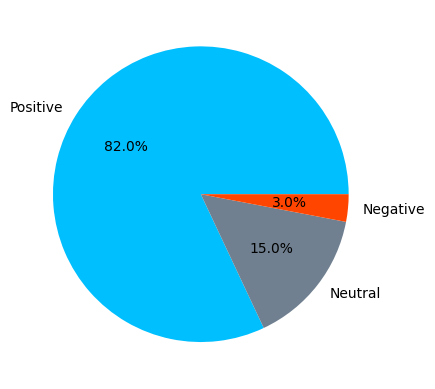

In [20]:
import matplotlib.pyplot as plt

labels = 'Positive', 'Neutral', 'Negative'
fig, ax = plt.subplots()
ax.pie(pnng, labels=labels, autopct='%1.1f%%', colors=['deepskyblue','slategray','orangered'])
print(pnng)

In [10]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.documents import Document

def openai_summarize(comments):
    docs = [Document(page_content=comment.text) for comment in comments]
    
    prompt = ChatPromptTemplate.from_messages(
        [("system", "Write a summary of the following youtube comments. Highlight specific comments and preserve user sentiment:\\n\\n{context}")]
    )
    
    llm = ChatOpenAI(model_name="gpt-4", temperature=0.5)
    chain = create_stuff_documents_chain(llm, prompt)

    result = chain.invoke({"context": docs})
    
    return result

In [11]:
s = False
if s:
    summary = openai_summarize(top_level_comments)
    print(summary)

The comments are overwhelmingly positive and appreciative of the video showcasing the inside of the pyramids in Egypt. Many Egyptians expressed pride in their history and civilization and thanked the creators for their effort in making the video. Some users wished for an extended cut of the video, as they found the content fascinating. There were also requests for similar content exploring other significant historical sites. Some users joked about the creators exploring Area 51 next. A few comments pointed out that this video was a perfect example of how money can provide access to exclusive experiences. Overall, the video was praised for its quality, with many calling it one of the best videos the creators have ever made.
